In [ ]:
# Run this if you wish to acces the file by pairing with your Google Drive
from google.colab import drive
drive.mount('/content/drive')

# NeuroPy week 3: Image analysis mini project

In this project, we will start with a short recording (about 60s) of calcium data recorded at 5 Hz in the forebrain of a larval zebrafish. The data has already been motion-corrected. The objectives here are to:
- Import the data;
- Segment neurons;
- Extract signal.

Some parts of the code are already written out for you to cover more ground and avoid too much repetition. You should however try your best to understand the parts that are already written out. The parts you have to fill are identified with **#TODO** or 'strings' with directions.

Before you start, it is important to upload the [file](https://drive.google.com/drive/folders/1yp0ak9PFHiliCQ-yei5ri193AJheNp9f?usp=sharing) we will be using for this exercice. You need to download the file from Google Drive and upload it in the contents folder of this notebook.

## 1. Importing modules

Here are the modules necessary to complete the mini-project

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import skimage
import cv2
import scipy

To save you some time, I wrote a simple function to calculate the autocorrelation of a signal. The concepts behind it are explore in the signal analysis mini project.

In [2]:
def compute_autocorrelations(signals):
  '''
  Compute the autocorrelation of an array of signals and returns and array with
  the autocorrelation coefficient of each signal
   '''
  autocorrs = []
  for signal in signals:
    autocorrs.append(np.correlate(signal, signal)[0])
  return np.array(autocorrs)

## 2. Importing Data

The first step in any type of analysis is understanding the data we are given. In this case, you could open the file in ImageJ before loading it in Python, to see what you have to work with. The first step is to load the stack. The function **imread** of the package [skimage.io](https://scikit-image.org/docs/stable/api/skimage.io.html#skimage.io.imread) lets you do that.

In [4]:
film_16b = skimage.io.imread(r"C:\Users\Sandrine Poulin\Downloads\20240628_12_21_58_3x_zoom_9dpf_920nm_workshop_XYTZ#5.tif")

Here are a few questions to answer:

1. How many images are in the stack and what is the dimension of each image?
      
      Hint: It may be a good idea to inspect the shape of your result. How would you acces a single frame? How would you track the value of a single pixel for the whole recording?
2. What data type are we dealing with?
      
      Hint: get the **data type** of a single pixel.

In [5]:
print(film_16b.shape)
print(type(film_16b[0,0,0]))

(310, 512, 512)
<class 'numpy.uint16'>


As you can see, we are dealing with [Unsigned 16-bits](https://doc.embedded-wizard.de/uint-type) images, which means we can have values ranging from 0 to 65535. While we could work with these images, we can make our life easier by transforming our images to Unsigned 8-bits data (values from 0 to 255). To do  so, we would have to use the formula:
$$ frame_{8bits} = \frac{255\times(frame_{16bits} - frame_{min})}{frame_{max}-frame_{min}}$$

$frame_{8bits}$: resulting frame in 8-bits (2D numpy array)

$frame_{16bits}$: resulting frame in 16-bits (2D numpy array)

$frame_{max}$: maximum value from the 16-bits image (int)

$frame_{min}$: minimum value from the 8-bits image (int)

This formula will yield an image with 0 as the most dim pixel and 255 as the most intense pixel. If you are having trouble implementing the solution, consider these tips:

1. You may want to **iterate** over every frame of your stack, apply the formula to the frame and store the result in a different array.
2. Your second movie (in 8-bits) will be an array with the same **shape** as your original movie (in 16-bits).

In [6]:
film_8b = np.zeros(film_16b.shape)

for i in range(film_16b.shape[0]):
  frame = film_16b[i]
  film_8b[i,:,:] = (255*((frame-np.min(frame))/(np.max(frame)-np.min(frame)))).astype(np.uint8)

Does a frame in 8-bits look different from a frame in 16-bits when using the **plt.imshow()** function?

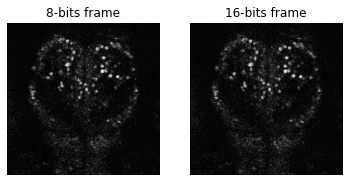

In [7]:
fig, (ax0,ax1) = plt.subplots(1,2)
ax0.imshow(film_8b[0], cmap = 'gray')
ax0.axis('off')
ax0.set_title('8-bits frame')

ax1.imshow(film_16b[0], cmap = 'gray')
ax1.axis('off')
ax1.set_title('16-bits frame')

plt.show()


Not really! While 16-bits will have a better 'color' depth, the difference here is hard to observe with our own eyes. We just wanted to do this step to make our life easier later. That being said, data with 16-bits images is more rich and I would not recommend down-sizing your data when doing analysis.

**Note for the rest of the mini-project:**

You are free to apply whatever parameters you judge best, but the idea at the end is to extract an interesting timeseries. Consequently, the neurons that are shown in the zoom-in below show a somewhat interesting activity, so I would encourage that you keep in mind that these neurons should be included in your segmentation.

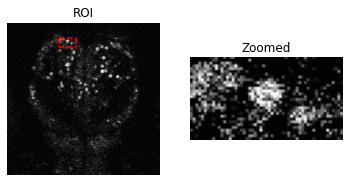

In [8]:
fig, (ax0,ax1) = plt.subplots(1,2)

ax0.imshow(film_8b[0], cmap = 'gray')
ax0.hlines([50,80],175,230,color='red',ls='--')
ax0.vlines([175,230],50,80,color='red',ls='--')
ax0.axis('off')
ax0.set_title('ROI')

ax1.imshow(film_8b[0,50:80,175:230],cmap='gray')
ax1.axis('off')
ax1.set_title('Zoomed')

plt.show()

## 3. Thresholding

The idea of the mini-project is to retrieve signal from our stack. To get our neuron's activity, we must first segment them. Before segmentation, however, comes the step of thresholding. Thresholding lets you get a binary image with everything with an intensity below a threshold as 0s everything above as 1s. The first step is to do a projection of our film. The two different types of projection we might be interested in will be the average projection and the maximum projection:


Do both projections and display them. What do you notice?

**Hint**: Is there a parameter of [numpy functions](https://numpy.org/doc/stable/reference/generated/numpy.mean.html) that could help you, considering your stack is  loaded as matrix of dimensions (number of frames, x pixels, y pixels)?

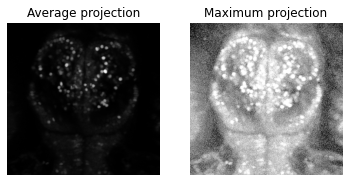

In [9]:
average_im = np.average(film_8b, axis=0).astype(np.uint8)
max_im = np.max(film_8b, axis=0).astype(np.uint8)

fig, (ax0,ax1) = plt.subplots(1,2)
ax0.imshow(average_im, cmap = 'gray')
ax0.axis('off')
ax0.set_title('Average projection')

ax1.imshow(max_im, cmap = 'gray')
ax1.axis('off')
ax1.set_title('Maximum projection')

plt.show()


- **Average projection**: Will help you see neurons that fired during the film, but also the ones that were bright the whole time. This method will also let you minimize the impact of noise and motion. You may loose neurons that do not fire during the acquisition.
- **Maximum projection**: Will help you see everything. Sensitive to motion artifacts.

Keeping in mind that thresholding is our goal, it should appear that the average projection is the way to go here. Display the histograms of pixel values to see how they are distributed.

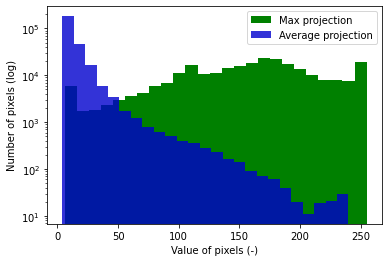

In [10]:
plt.hist(max_im.flatten(),bins=25,log=True,color='green',label='Max projection')
plt.hist(average_im.flatten(),bins=25,log=True,color='mediumblue',alpha=0.8,label='Average projection')
plt.legend()
plt.ylabel('Number of pixels (log)')
plt.xlabel('Value of pixels (-)')
plt.show()

The distribution of the maximum projection really seems harder to work with than the average projection. Let's keep working with the average projection.

#### Manual threshold

The first option when doing thresholding is choosing a threshold manually. Choose a threshold and apply it to your image.

**Hint:** You can do the following operation with arrays
        
          array2 = array1 > value

This will give an array2 with the same size as array1. The values in this array will be True if the condition is respected and False if it is not. You can then use

        array2 = array2.astype(int)

To replace the Trues with 1s and the Falses with 0s and obtain a binary image.

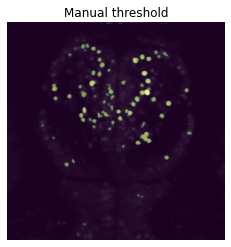

In [11]:
th = 60

binary = average_im >= th

plt.title('Manual threshold')
plt.imshow(average_im,cmap='gray')
plt.imshow(binary,alpha=0.4)
plt.axis('off')
plt.show()

Now that is probably not the best way to go. Another way to find a threshold is to let python calculate it. Here, you may want to use the [cv2.threshold](https://docs.opencv.org/4.x/d7/d4d/tutorial_py_thresholding.html) method for simple thresholding, you should try different thresholds to see the one you like the most. Here are different thresholds that  are available to use:
 - cv2.THRESH_OTSU
 - cv2.THRESH_TRIANGLE

It is possible to apply a multiplication factor to the value of the threshold to make it more or less harsh. Re-use the same logic as earlier to apply the threshold to your image.

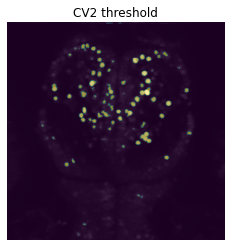

In [12]:
th, _ = cv2.threshold(average_im, 0, 255, cv2.THRESH_TRIANGLE)
binary = average_im >= 2*th

plt.title('CV2 threshold')
plt.imshow(average_im,cmap='gray')
plt.imshow(binary,alpha=0.4)
plt.axis('off')
plt.show()

As you can see, it is possible to obtain similar results in a more rigourous manner. We now have a first draft of binary image. As you can see, some neurons touch, and some neurons just appear as small blobs.

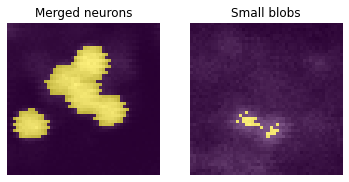

In [13]:
fig, (ax0,ax1) = plt.subplots(1,2)

ax0.imshow(average_im[250:300,300:350],cmap='gray')
ax0.imshow(binary[250:300,300:350],alpha=0.6)
ax0.axis('off')
ax0.set_title('Merged neurons')

ax1.imshow(average_im[375:425,290:340],cmap='gray')
ax1.imshow(binary[375:425,290:340],alpha=0.6)
ax1.axis('off')
ax1.set_title('Small blobs')

plt.show()

Thankfully, the module OpenCV (here imported as cv2) lets us peform many oprations on our binary images. The first thing we could try is an [erosion](https://docs.opencv.org/3.4/d4/d86/group__imgproc__filter.html#gaeb1e0c1033e3f6b891a25d0511362aeb). This operation keeps the minimal value in a specified radius around each pixel. It will take out a layer around each blob and eliminate smaller ones. What we want here is to eliminate as many small blobs as possible without losing our interesting neurons.

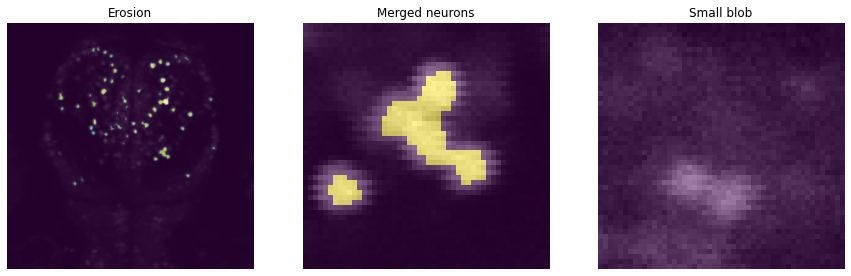

In [14]:
erosion_radius = 4
eroded = cv2.erode(binary.astype('uint8'), np.ones((erosion_radius,erosion_radius)))

fig, (ax0,ax1,ax2) = plt.subplots(1,3,figsize=(15,5))

ax0.imshow(average_im,cmap='gray')
ax0.imshow(eroded,alpha=0.5)
ax0.axis('off')
ax0.set_title('Erosion')

ax1.imshow(average_im[250:300,300:350],cmap='gray')
ax1.imshow(eroded[250:300,300:350],alpha=0.5)
ax1.axis('off')
ax1.set_title('Merged neurons')

ax2.imshow(average_im[375:425,290:340], cmap='gray')
ax2.imshow(eroded[375:425,290:340], alpha=0.5)
ax2.axis('off')
ax2.set_title('Small blob')

plt.show()

While we did get rid of our small blobs, we somewhat lost the shap of our interesting neurons. We should try to undo the effect of erosion on our bigger blobs to retrieve the original shape.

The dilation is the operation contrary to the erosion. It is done with a [function by OpenCV](https://docs.opencv.org/3.4/d4/d86/group__imgproc__filter.html#ga4ff0f3318642c4f469d0e11f242f3b6c).
It will choose the maximum intensity vlaue in a specified radius around each pixel. Here, you can use it to obtain your original image-ish, without the small blobs.

What you want to do here is find an appropriate dilation radius that let you segment as much of your neurons as possible, withouth them being too big. As the structure is the same for erosion and dilation, you only need to choose an appropriate radius.

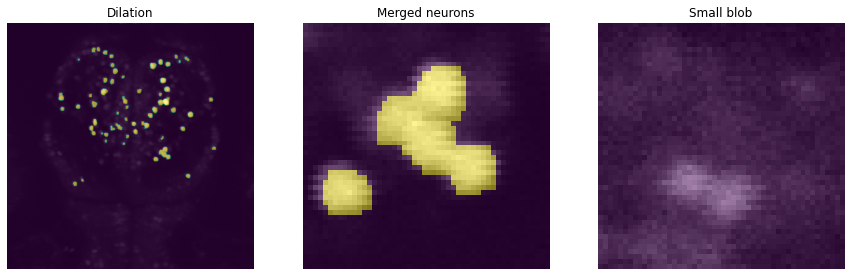

In [15]:
dilation_radius = 4

dilated = cv2.dilate(eroded.astype('uint8'),np.ones((dilation_radius,dilation_radius)))

fig, (ax0,ax1,ax2) = plt.subplots(1,3,figsize=(15,5))

ax0.imshow(average_im,cmap='gray')
ax0.imshow(dilated,alpha=0.5)
ax0.axis('off')
ax0.set_title('Dilation')

ax1.imshow(average_im[250:300,300:350],cmap='gray')
ax1.imshow(dilated[250:300,300:350],alpha=0.5)
ax1.axis('off')
ax1.set_title('Merged neurons')

ax2.imshow(average_im[375:425,290:340], cmap='gray')
ax2.imshow(dilated[375:425,290:340], alpha=0.5)
ax2.axis('off')
ax2.set_title('Small blob')

plt.show()

Now, we've got a good binary image with some interesting neurons, we can move on to segmentation.

## 4. Segmentation using Opencv

This is a very basic example of segmentation that could be used on images where neurons are sparse and big. More complex packages and tools for segmetation, like [Cellpose](https://www.cellpose.org/) or [Suite2p](https://www.suite2p.org/) should be looked into for more complex situations. This pipeline aims to give a good idea of the different operations available to do simple segmentation.

The first tool we can use is OpenCV's [connecteComponentsWithStats](https://docs.opencv.org/3.4/d3/dc0/group__imgproc__shape.html#ga107a78bf7cd25dec05fb4dfc5c9e765f) function. This will let us separated ans label our different blobs. As OpenCV's documentation isn't the easiest to read, here is the bottom line:

      cv2.connectedComponentsWithStats(input_image(type:uint8)) -> returns: (totalLabels, labelIds, stats, centroid)
      totalLabels: Number of regions
      labelIds: array of the size of the image where the value represent the number of the label (0=No label)
      stats: stats computed (look at the parameter stats in the documentation for syntax)
      centroid: centroid of each region

The first thing we might want to do is display our image and look at the size of our regions. In the cell below:

1. Use the cv2.connectedComponentWitStats function to do a first round of segmentation.
2. Find the right way to retrieve the area of your regions using the right output and [structure](https://docs.opencv.org/3.4/d3/dc0/group__imgproc__shape.html#gac7099124c0390051c6970a987e7dc5c5).
3. Extract your labelled image and assign it to a variable (for later use)

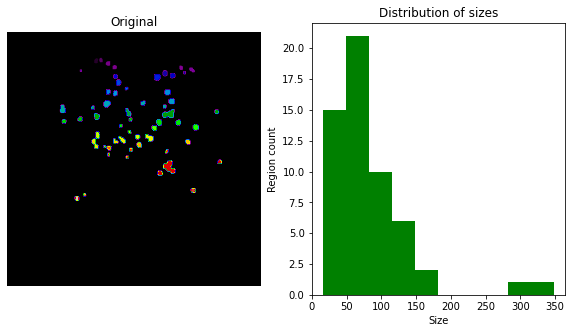

In [16]:
analysis = cv2.connectedComponentsWithStats(dilated)
(totalLabels, labelIds, stats, centroid)  = analysis
pre_filtering = np.copy(labelIds)

sizes = stats[:, cv2.CC_STAT_AREA]

fig, (ax0,ax1) = plt.subplots(1,2,figsize=(10,5))
ax0.imshow(pre_filtering, cmap='nipy_spectral')
ax0.set_title("Original")
ax0.axis('off')

ax1.hist(sizes[1:],color = 'green')
ax1.set_xlabel('Size')
ax1.set_ylabel('Region count')
ax1.set_title('Distribution of sizes')

plt.show()

**Fun fact**: everything set at 0 will also be considered a blob and will always be considered the blob 0. Thus, the region 0 in your data set iis representative of your whole background.

Considering this, you should not be seeing only 2 bars in your histogram and the maximum size should be located at around 350.

From there, it could be interesting to filter our data according to size, as the neurons in our image have similar sizes. In our case, regions that are too big may be neurons that are merged and regions that are too small may be neurons that just aren't bright enough. In both cases, we do not necessarily want to keep them in our analysis. In the cell below, you should:

1. Choose minimum and maximum sizes for your region based on your histogram above
2. Complete the for-loop. The goal of this loop is to iterate over all your regions (except region 0) , check

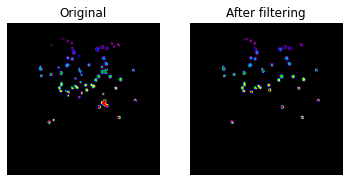

In [17]:
min_size = 50
max_size = 150

post_filtering = np.zeros(pre_filtering.shape)

for i in range(1, totalLabels):
  if max_size >= sizes[i] >= min_size:
    post_filtering[pre_filtering == i] = 255

# Another round of segmentation over the filtered image

analysis = cv2.connectedComponentsWithStats(post_filtering.astype('uint8'))
(totalLabels, label_ids, values, centroid)  = analysis
post_filtering = np.copy(label_ids)

fig, (ax0,ax1) = plt.subplots(1,2)
ax0.imshow(pre_filtering, cmap='nipy_spectral')
ax0.set_title("Original")
ax0.axis('off')

ax1.imshow(post_filtering, cmap='nipy_spectral')
ax1.set_title("After filtering")
ax1.axis('off')

plt.show()

Now, we ant to use the **centroids** we found to ensure that these neurons are really located on our original image. Here, you must find the right way to display the centroids you found in the cell above

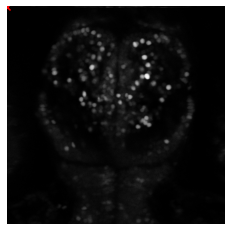

In [18]:
plt.imshow(average_im,cmap='gray')
plt.scatter("centroid's first coordinate", "centroid's second coordinate", marker = 'x', color = 'red')
plt.axis('off')

plt.show()

## 5. Extracting timeseries

Now is the time to extract timeseries from our segmentation. This is the point where we bring back our stack from the beginning, merge it with our segmentation and find neuronal activity.

If you are stuck, try considering these tips:
1. You want to iterate over your labels and get a mask of your region label (which will be an array of the size of one frame with 1s where the neuron is and 0s everywhere else).
2. You want to apply this mask to everyframe of your stack (remember that you can multiply python arrays). From this point you have a stack with your fluorescence values only for your neuron. You might want to extract the mean, or the sum of fluorescence for all your pixels to get a single value at every time point of your stack.

In [19]:
timeseries = []
for i in range(1,totalLabels):
  mask = label_ids == i
  masked_film = film_8b*mask
  timeseries.append(np.mean(masked_film, axis=(1,2)))

There are many ways to display our timeseries. Here are two ways. You can change the slicing of the timeseries variable to obtain a better view. Before plotting, timseries are sorted according their autocorrelation to facilitate observations.

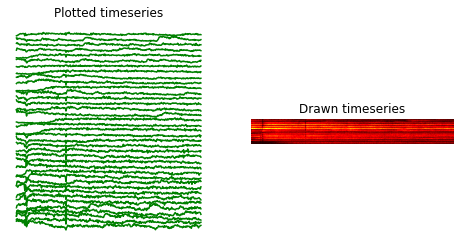

In [20]:
timeseries = np.array(timeseries)
correlations = np.argsort(compute_autocorrelations(timeseries))
timeseries_sorted = timeseries[correlations]

fig, (ax0,ax1) = plt.subplots(1,2,figsize=(8,4))

h = 0
for ts in timeseries_sorted[:]: # You can change the slicing here
  ax0.plot(ts - h, color = 'green')
  h +=0.03

ax0.axis('off')
ax0.set_title('Plotted timeseries')

ax1.imshow(timeseries, cmap = 'hot')
ax1.axis('off')
ax1.set_title('Drawn timeseries')

plt.show()

Here, the imshow function is not the best ways, as most our neurons have ugly traces, so we might want to use a zoomed version of the plotted timeseries. Let's look at three different traces

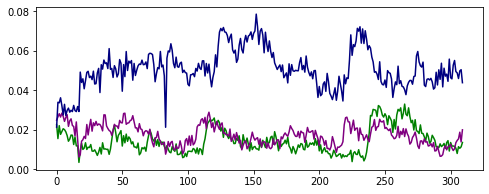

In [21]:
plt.figure(figsize=(8,3))
plt.plot(timeseries_sorted[1], color='green')
plt.plot(timeseries_sorted[5], color='purple')
plt.plot(timeseries_sorted[-5], color='navy')
plt.show()

If your segmentation is the same as mine's, these three traces should be somewhat interesting. Let's write their data in a dictionary.

In [22]:
interesting_ids = [1,5,-5]
my_neurons = {'centroids':[],'timeseries':[]}

for interesting_id in interesting_ids:
  neuron_id = correlations[interesting_id] # finding what is the neuron's label
  my_neurons['centroids'].append(centroid[neuron_id + 1]) # finding its centroid (we need to do +1 as the centroid was found before removing the region 0)
  my_neurons['timeseries'].append(timeseries[neuron_id]) # getting the timeseries

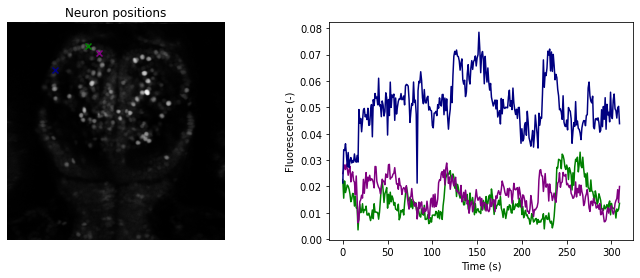

In [23]:
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(12,4))

ax0.imshow(average_im,cmap='gray')
ax0.scatter(my_neurons['centroids'][0][0],my_neurons['centroids'][0][1],color='green',marker='x')
ax0.scatter(my_neurons['centroids'][1][0],my_neurons['centroids'][1][1],color='purple',marker='x')
ax0.scatter(my_neurons['centroids'][2][0],my_neurons['centroids'][2][0],color='navy',marker='x')
ax0.axis('off')
ax0.set_title('Neuron positions')

ax1.plot(my_neurons['timeseries'][0], color='green')
ax1.plot(my_neurons['timeseries'][1], color='purple')
ax1.plot(my_neurons['timeseries'][2], color='navy')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Fluorescence (-)')

plt.show()

#### Saving data

Your almost done! Your last job will be to save the data in a .csv file. Using a function from [pandas](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html).

The data is in a dictionary assigned to the name my_neurons.

In [24]:
df = pd.DataFrame(my_neurons)

df.to_csv('my_neurons.csv')

## (extra) 6. Segmentation using skimage

Segmentation can also be done using the package skimage. The code is not so easy to do, so most of it is writtent out for you, what you must do is feed the code the right image and play with the MIN_DISTANCE parameter to find  goog segmentation. The code will find local maxima in the image and perform segmentation with a consideration for these local maxima.

In [25]:
MIN_DISTANCE = 4
image = dilated

labeled_cells = skimage.measure.label(image)
distance = scipy.ndimage.distance_transform_edt(image)

local_max_coords = skimage.feature.peak_local_max(distance, min_distance=MIN_DISTANCE)
local_max_mask = np.zeros_like(distance, dtype=bool)
local_max_mask[tuple(local_max_coords.T)] = True

markers = skimage.measure.label(local_max_mask)
segmented_cells = skimage.segmentation.watershed(-distance, markers, mask=image)

In [26]:
# Print/Display different parts of the code above here to understand what each item is

In the cell below, replace the elements in the imshow and scatter functions to display a map with labeled centroids and another one of the differen regions found. This is where you can verify whether the MIN_DISTANCE parameter you chose was appropriate or not.

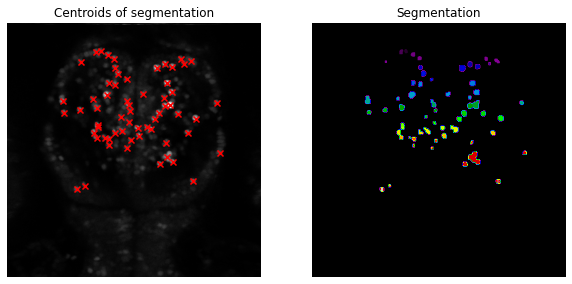

In [27]:
fig, (ax0, ax1) = plt.subplots(1,2,figsize=(10,5))

ax0.imshow(average_im, cmap='gray')
ax0.scatter(local_max_coords[:, 1], local_max_coords[:, 0], marker='x', color='r')
ax0.axis('off')
ax0.set_title('Centroids of segmentation')

ax1.imshow(segmented_cells, cmap='nipy_spectral')
ax1.axis('off')
ax1.set_title('Segmentation')

plt.show()

What about our merged neurons from the other example? Did the local maximum algorithm help seperate neurons that are close by?

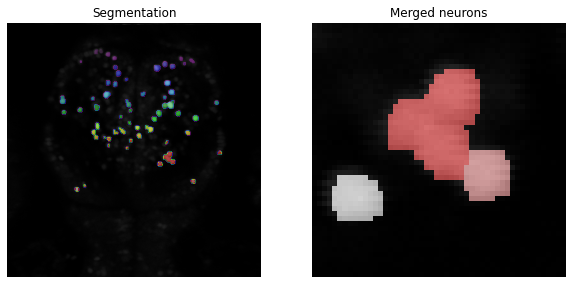

In [28]:
fig, (ax0,ax1) = plt.subplots(1,2,figsize=(10,5))

ax0.imshow(average_im,cmap='gray')
ax0.imshow(segmented_cells,cmap='nipy_spectral',alpha=0.5)
ax0.axis('off')
ax0.set_title('Segmentation')

ax1.imshow(average_im[250:300,300:350],cmap='gray')
ax1.imshow(segmented_cells[250:300,300:350],cmap='nipy_spectral',alpha=0.8)
ax1.axis('off')
ax1.set_title('Merged neurons')

plt.show()

As you can see, it somewhat succeeded, but isn't perfect. While it is better than simple segmentation, more complex algorithms are needed to segment our neurons.

#### Extracting timeseries

You can now adjust the code you made earlier to extract your timeseries and apply it to your new segmentation

In [29]:
timeseries = []
for i in range(1,np.max(markers)):
  mask = segmented_cells == i
  masked_film = film_8b*mask
  timeseries.append(np.mean(masked_film, axis=(1,2)))

Let's display our timeseries!

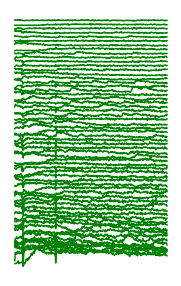

In [30]:
timeseries = np.array(timeseries)
correlations = np.argsort(compute_autocorrelations(timeseries))
timeseries_sorted = timeseries[correlations]

h = 0
plt.figure(figsize=(3,5))
for ts in timeseries_sorted[:]:
  plt.plot(ts - h, color = 'green')
  h +=0.02

plt.axis('off')
plt.show()

We obtain similarily the same timeseries, using another method!

## Conclusion

In this mini-project, you:
- Imported data and played with data types
- Thresholded images and played with binary images
- Segmented neurons
- Extracted timseries

As mentioned earlier, this is not the most robust image segmentation, but it gives a good idea  of the operations available to do in Python.



This Notebook was created and the data was acquired by Sandrine Poulin. Please do not share notebook or data without my permission. If you have any questions, you can always contact me (sandrine.poulin.3@ulaval.ca)